## In this script we will do a preliminary data exploration
### 1) Pre-cleaning
### 2) Plot the overall sales
### 3) Plot the relative contribution from each category for both sites

In [12]:
%matplotlib inline
import numpy as np
import pandas as pd

import datetime

import matplotlib.pyplot as plt
import pylab
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import statsmodels.api as sm  
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf, q_stat
from statsmodels.graphics.gofplots import qqplot

from sklearn.metrics import mean_squared_error
from math import sqrt

In [13]:
np.random.seed(42)
data_A = pd.read_csv('../data/siteA.csv')
data_B = pd.read_csv('../data/siteB.csv')

# Step 1) Cleaning

In [14]:
data_A['Date_Name'] = data_A['Date_Name'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))
data_B['Date_Name'] = data_B['Date_Name'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))

In [15]:
data_A_grouped = data_A.groupby(by=['Date_Name'])['sales'].sum()
data_B_grouped = data_B.groupby(by=['Date_Name'])['sales'].sum()

In [20]:
print data_A_grouped.head()
print data_B_grouped.head()

Date_Name
2015-09-26    14588.23
2015-09-27    15143.61
2015-09-28    84535.83
2015-09-29    94145.18
2015-09-30    91173.07
Name: sales, dtype: float64
Date_Name
2015-09-26     5370.26
2015-09-27     5051.38
2015-09-28    11937.56
2015-09-29    11788.07
2015-09-30    11995.37
Name: sales, dtype: float64


# Step 2) Overall plot

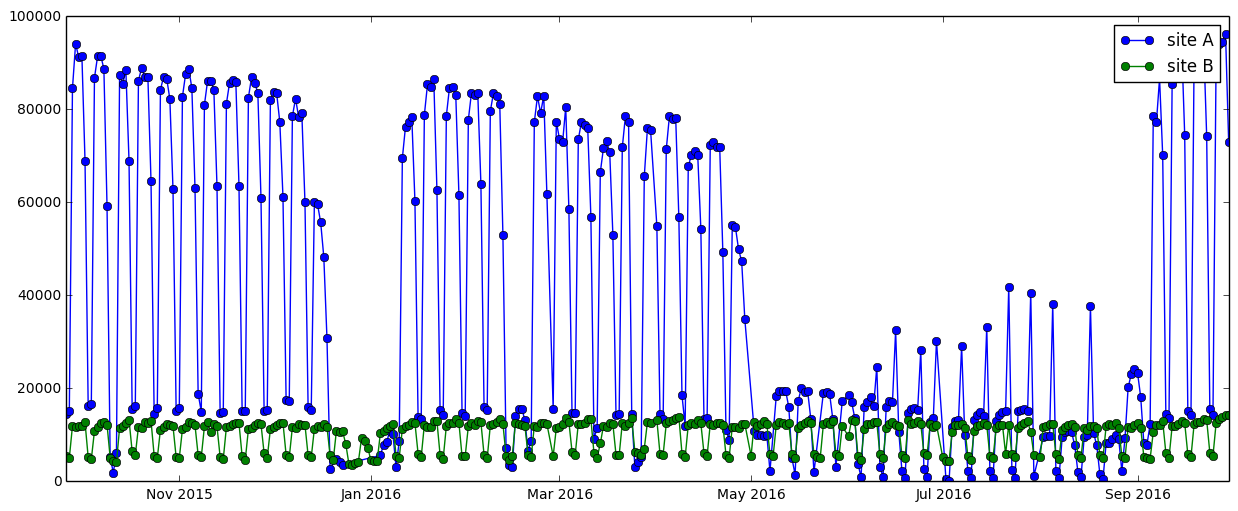

In [21]:
plt.plot(data_A_grouped.index, data_A_grouped, '-o', label='site A')
plt.plot(data_B_grouped.index, data_B_grouped, '-o', label='site B')
plt.legend()

### Site A: X'Mas, summer low sales volume -> follows University schedule
### Site B: Steady sales, except for small dip during X'Mas season
### Both shows weekly seasonal behavior -> low sales during the weekend, more sales during the weekdays

In [25]:
# Make a dataframe for each category, and put it into a list.
# Essentially becomes a list of dataframe

def make_dataframe(df, lis):
    f = lambda x: df[df['subCategory'] == x]
    return map(f, lis)

temp_list_A = data_A['subCategory'].unique()
temp_list_B = data_B['subCategory'].unique()

splitted_data_A = make_dataframe(data_A, temp_list_A)
splitted_data_B = make_dataframe(data_B, temp_list_B)

print 'For example 3rd category from siteA: \n', splitted_data_A[2][0:5]

For example 3rd category from siteA: 
      Date_Name subCategory  Purchase_Hour   sales
9259 2016-03-01           C              7  460.34
9260 2016-03-04           C              7  414.03
9261 2016-03-07           C              7  370.37
9262 2016-03-08           C              7  368.68
9263 2016-03-11           C              7  439.15


In [29]:
def group_splitted_data(splitted_data, temp_list):
    idx = pd.date_range('09-26-2015', '09-30-2016')
    for i, item in enumerate(temp_list):
        splitted_data[i] = splitted_data[i].groupby(by=['Date_Name'])['sales'].sum()
        print item, ':', splitted_data[i].shape

        # We fill in the missing dates with value 0. Because this may be holiday and the shop made 0 sales.
        splitted_data[i].index = pd.DatetimeIndex(splitted_data[i].index)
        splitted_data[i] = splitted_data[i].reindex(idx, fill_value=0)
        print item, ':', splitted_data[i].shape, '-', splitted_data[i].index

    print '\n', splitted_data[0].head()
    return splitted_data

In [35]:
group_splitted_data(splitted_data_A, temp_list_A)
group_splitted_data(splitted_data_B, temp_list_B)

A : (365,)
A : (371,) - DatetimeIndex(['2015-09-26', '2015-09-27', '2015-09-28', '2015-09-29',
               '2015-09-30', '2015-10-01', '2015-10-02', '2015-10-03',
               '2015-10-04', '2015-10-05',
               ...
               '2016-09-21', '2016-09-22', '2016-09-23', '2016-09-24',
               '2016-09-25', '2016-09-26', '2016-09-27', '2016-09-28',
               '2016-09-29', '2016-09-30'],
              dtype='datetime64[ns]', length=371, freq='D')
B : (365,)
B : (371,) - DatetimeIndex(['2015-09-26', '2015-09-27', '2015-09-28', '2015-09-29',
               '2015-09-30', '2015-10-01', '2015-10-02', '2015-10-03',
               '2015-10-04', '2015-10-05',
               ...
               '2016-09-21', '2016-09-22', '2016-09-23', '2016-09-24',
               '2016-09-25', '2016-09-26', '2016-09-27', '2016-09-28',
               '2016-09-29', '2016-09-30'],
              dtype='datetime64[ns]', length=371, freq='D')
C : (364,)
C : (371,) - DatetimeIndex(['2015-09-26',

# Step 3) Relative contribution plot

In [58]:
def relative_cont_plot(category_grouped, total_grouped, item, y_range):
    category = category_grouped / total_grouped
    if category.mean() >= 0.08:
        print 'Category {} Sales Contribution: '.format(item), category.mean()
    _ = plt.plot(category.index, category, label=item)
    _ = plt.legend(loc='right')
    _ = plt.title('Relative Contribution from Each Category')
    _ = plt.ylim(0, y_range)

Site A - Top contributors are...
Category B Sales Contribution:  0.0993248963117
Category F Sales Contribution:  0.213298820052
Category M Sales Contribution:  0.138217874707
Category N Sales Contribution:  0.180146222081
Category O Sales Contribution:  0.157342925854


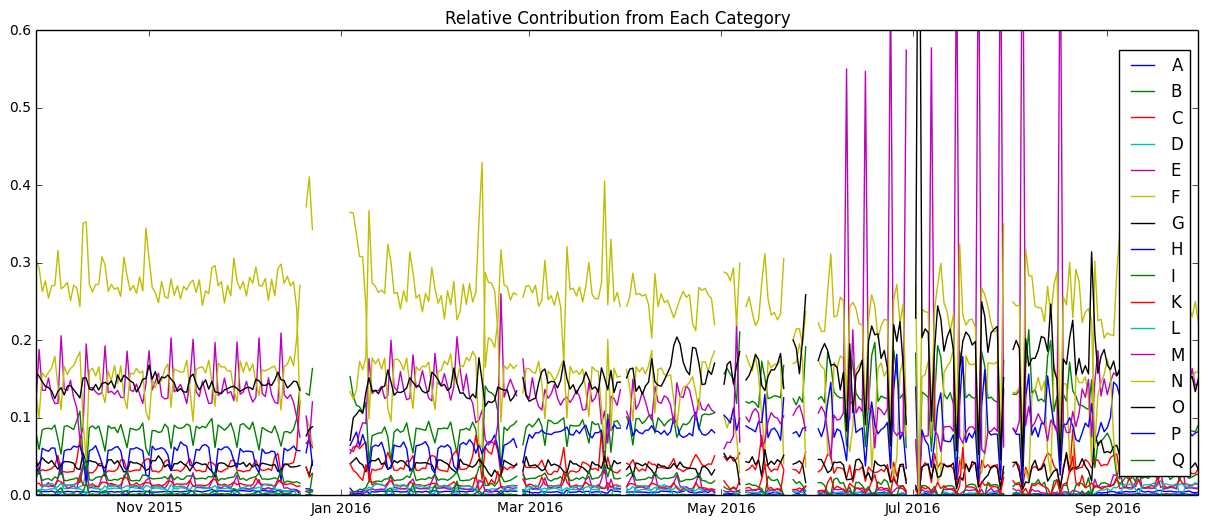

In [53]:
print 'Site A - Top contributors are...'
_ = map(relative_cont_plot, splitted_data_A, [data_A_grouped]*len(temp_list_A), temp_list_A, [0.6]*len(temp_list_A))

Site B - Top contributors are...
Category B Sales Contribution:  0.143160143152
Category F Sales Contribution:  0.112698346961
Category M Sales Contribution:  0.116984539976
Category N Sales Contribution:  0.288146890729
Category O Sales Contribution:  0.109347891749


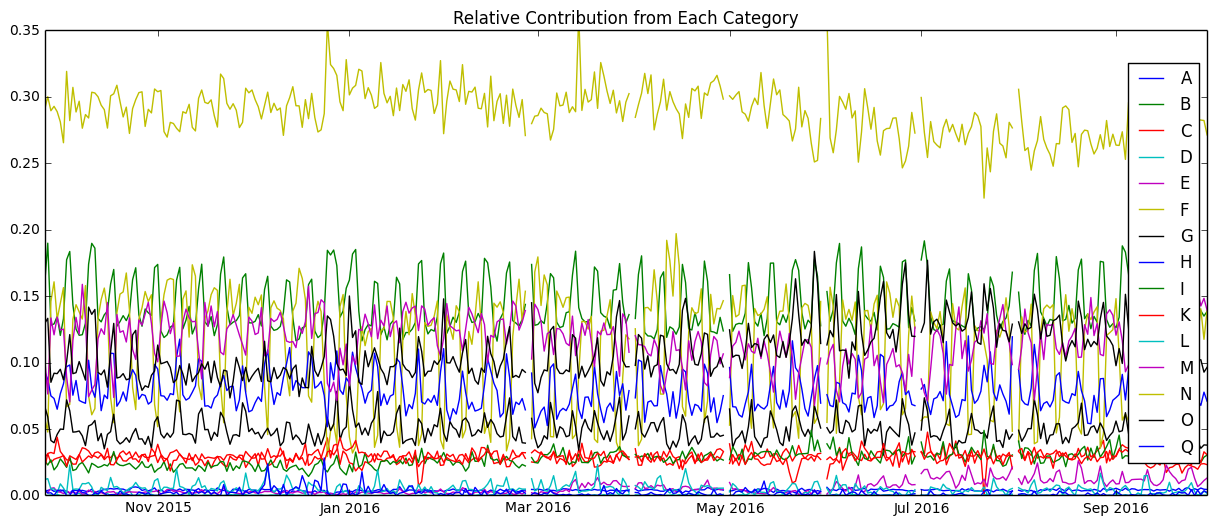

In [55]:
print 'Site B - Top contributors are...'
_ = map(relative_cont_plot, splitted_data_B, [data_B_grouped]*len(temp_list_B), temp_list_B, [0.35]*len(temp_list_B))

# Summary:
## - Some anomalies present in site A, not much in site B
## - Site B has steady, consistent sales
## - Both have a category that has sales for only 1/2 of the dates
## - Site A follows a university-like schedule: X'Mas & summer off
## - Both sites have a top 4~5 categories that contributed to ~ 70% of the sales; out of 14~15 categories.
## - We will do more statistical testing for both sites in separates scripts: in general, site B is more stationary than site A